In [1]:
!pip install opendatasets
!pip install pandas
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download sachchitkunichetty/rvf10k

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rathodharsh
Your Kaggle Key: ··········


100%|██████████| 273M/273M [00:08<00:00, 35.7MB/s]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import random


In [5]:
train_df = pd.read_csv("/content/rvf10k/train.csv")
valid_df = pd.read_csv("/content/rvf10k/valid.csv")

In [6]:
train_df.head()

,Unnamed: 0,original_path,id,label,label_str,path
0,1052,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,28609,1,real,train/real/28609.jpg
1,13406,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,30395,1,real,train/real/30395.jpg
2,16376,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,22430,1,real,train/real/22430.jpg
3,31373,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,58380,1,real,train/real/58380.jpg
4,21034,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,62044,1,real,train/real/62044.jpg


In [7]:
valid_df.head()

,Unnamed: 0,original_path,id,label,label_str,path
0,15833,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24731,1,real,valid/real/24731.jpg
1,12725,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02004,1,real,valid/real/02004.jpg
2,26970,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,68164,1,real,valid/real/68164.jpg
3,33347,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,39647,1,real,valid/real/39647.jpg
4,40138,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,49014,1,real,valid/real/49014.jpg


In [8]:
train_df.columns

Index(['Unnamed: 0', 'original_path', 'id', 'label', 'label_str', 'path'], dtype='object')

In [9]:
valid_df.columns

Index(['Unnamed: 0', 'original_path', 'id', 'label', 'label_str', 'path'], dtype='object')

In [10]:
train_df['label'].value_counts()

label
1    3500
0    3500
Name: count, dtype: int64

In [11]:
train_df['label_str'].value_counts()

label_str
real    3500
fake    3500
Name: count, dtype: int64

In [12]:
def load_and_preprocess_images(df):
    images = []
    labels = []

    for index, row in df.iterrows():
        image_path = row['path']
        label = row['label']

        image = cv2.imread(f'rvf10k/rvf10k/{image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

In [13]:
train_images, train_labels = load_and_preprocess_images(train_df)

In [14]:
train_images.shape

(7000, 256, 256, 3)

array([[[ 57,  50,  57],
        [ 50,  45,  49],
        [ 48,  46,  49],
        ...,
        [249, 253, 255],
        [249, 253, 255],
        [249, 253, 255]],

       [[ 47,  40,  47],
        [ 44,  39,  43],
        [ 46,  44,  45],
        ...,
        [246, 250, 253],
        [247, 251, 254],
        [248, 252, 255]],

       [[ 46,  39,  46],
        [ 45,  40,  44],
        [ 49,  47,  48],
        ...,
        [246, 250, 251],
        [247, 251, 252],
        [248, 252, 253]],

       ...,

       [[182, 139,  34],
        [186, 144,  36],
        [180, 139,  31],
        ...,
        [236, 243, 249],
        [239, 243, 252],
        [237, 241, 250]],

       [[190, 146,  39],
        [189, 145,  38],
        [182, 140,  32],
        ...,
        [235, 242, 252],
        [236, 239, 254],
        [230, 233, 248]],

       [[199, 155,  46],
        [191, 147,  38],
        [185, 141,  36],
        ...,
        [231, 237, 249],
        [228, 231, 248],
        [219, 222, 241]]], dtype=uint8)
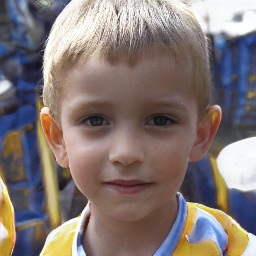

In [15]:
train_images[6999]

In [16]:
valid_images, valid_labels = load_and_preprocess_images(valid_df)

array([[[214, 216, 215],
        [214, 216, 215],
        [214, 216, 215],
        ...,
        [206, 206, 206],
        [205, 205, 205],
        [204, 204, 204]],

       [[214, 216, 215],
        [214, 216, 215],
        [214, 216, 215],
        ...,
        [205, 205, 205],
        [205, 205, 205],
        [204, 204, 204]],

       [[213, 215, 214],
        [213, 215, 214],
        [213, 215, 214],
        ...,
        [205, 205, 205],
        [205, 205, 205],
        [204, 204, 204]],

       ...,

       [[235, 237, 236],
        [232, 234, 231],
        [233, 235, 234],
        ...,
        [222, 224, 223],
        [214, 214, 216],
        [210, 210, 212]],

       [[232, 237, 233],
        [232, 237, 231],
        [233, 235, 232],
        ...,
        [217, 218, 220],
        [223, 222, 227],
        [214, 213, 218]],

       [[230, 235, 229],
        [228, 233, 227],
        [198, 200, 195],
        ...,
        [203, 204, 206],
        [204, 203, 208],
        [208, 207, 213]]], dtype=uint8)
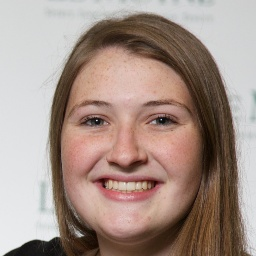

In [17]:
valid_images[76]

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [19]:
base_model.trainable = False

In [20]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

In [21]:
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [22]:
valid_images, test_images, valid_labels, test_labels = train_test_split(valid_images, valid_labels, test_size=0.5, random_state=42)

In [23]:
history = model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(valid_images, valid_labels))

Epoch 1/100
219/219 [==============================] - 71s 274ms/step - loss: 2.4469 - accuracy: 0.6840 - val_loss: 0.4272 - val_accuracy: 0.8147
Epoch 2/100
219/219 [==============================] - 43s 197ms/step - loss: 0.4630 - accuracy: 0.7771 - val_loss: 0.4064 - val_accuracy: 0.8393
Epoch 3/100
219/219 [==============================] - 45s 207ms/step - loss: 0.3887 - accuracy: 0.8239 - val_loss: 0.3639 - val_accuracy: 0.8347
Epoch 4/100
219/219 [==============================] - 46s 212ms/step - loss: 0.3212 - accuracy: 0.8533 - val_loss: 0.3598 - val_accuracy: 0.8560
Epoch 5/100
219/219 [==============================] - 46s 209ms/step - loss: 0.2790 - accuracy: 0.8677 - val_loss: 0.3490 - val_accuracy: 0.8413
Epoch 6/100
219/219 [==============================] - 43s 198ms/step - loss: 0.2359 - accuracy: 0.8919 - val_loss: 0.3958 - val_accuracy: 0.8547
Epoch 7/100
219/219 [==============================] - 46s 209ms/step - loss: 0.2275 - accuracy: 0.8939 - val_loss: 0.3880 -

In [24]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

47/47 [==============================] - 8s 159ms/step - loss: 1.5135 - accuracy: 0.8607
Test Loss: 1.5134642124176025
Test Accuracy: 0.8606666922569275


In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

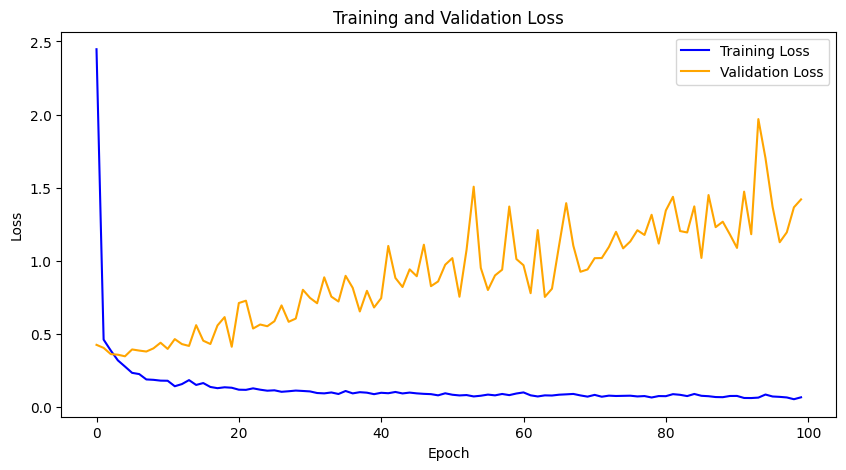

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

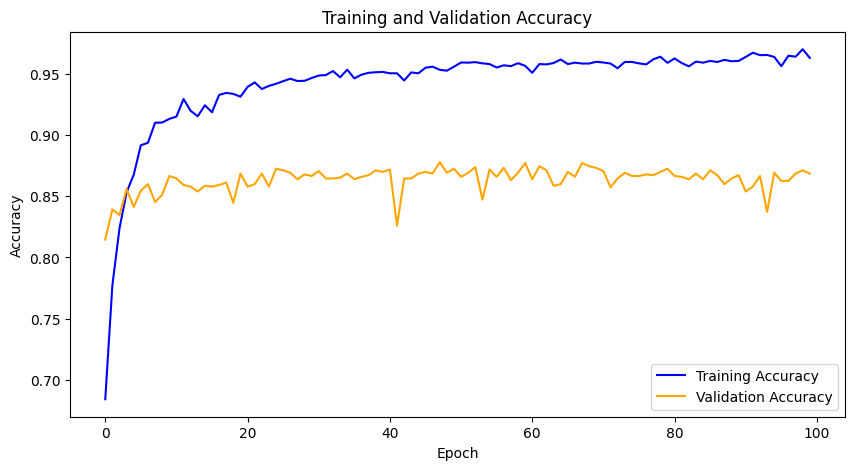

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
predictions = model.predict(test_images)

47/47 [==============================] - 8s 162ms/step


In [29]:
binary_predictions = (predictions > 0.5).astype("int32")

from sklearn.metrics import classification_report
print(classification_report(test_labels, binary_predictions))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       736
           1       0.87      0.85      0.86       764

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



In [30]:
confusion_matrix(test_labels,binary_predictions)

array([[639,  97],
       [112, 652]])

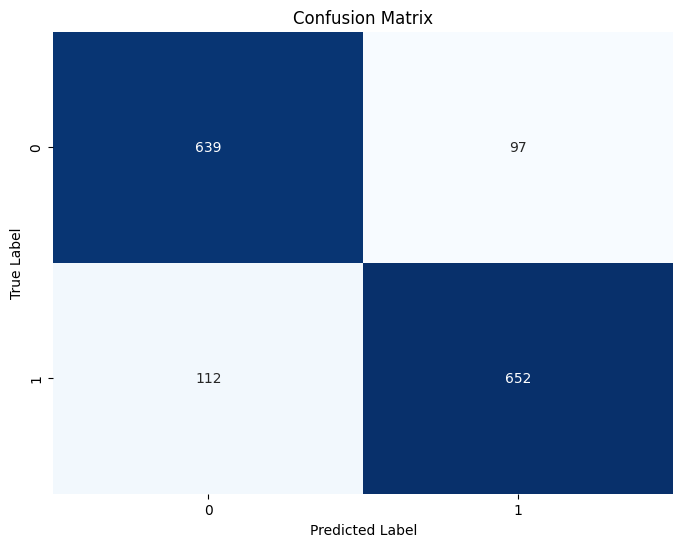

In [31]:
conf_matrix = confusion_matrix(test_labels,binary_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [32]:
indices = np.random.choice(len(test_images), size=64, replace=False)

In [33]:
sample_images = test_images[indices]
sample_labels = test_labels[indices]

In [34]:
predic = model.predict(sample_images)


2/2 [==============================] - 0s 198ms/step


In [35]:
binary_pred = (predic > 0.5).astype(int)

In [37]:
accur = np.mean(binary_pred.flatten() == sample_labels)

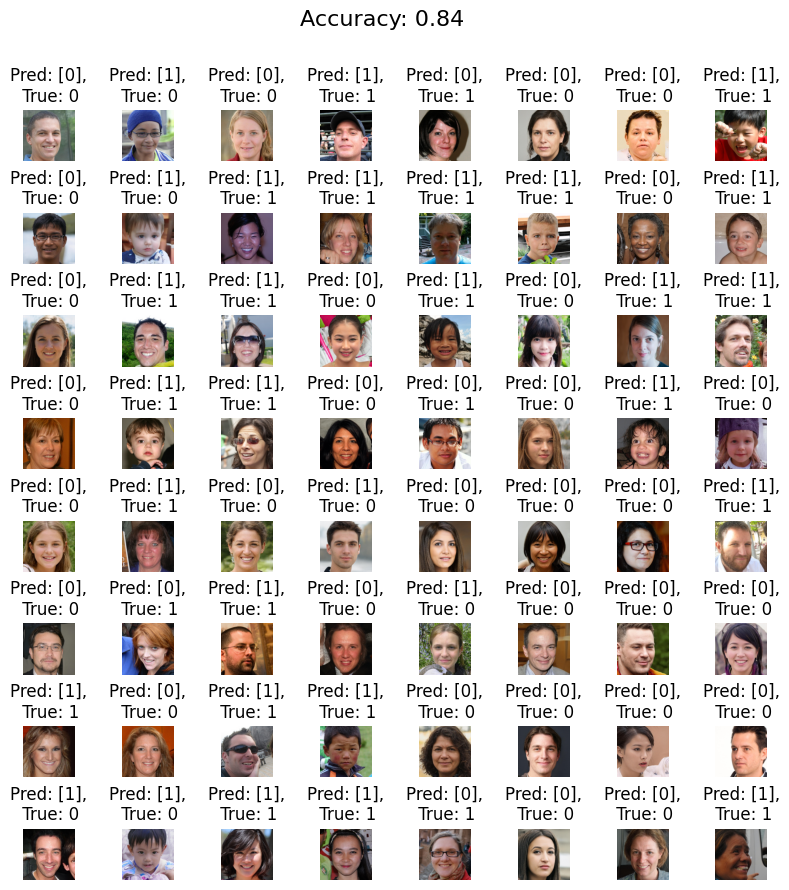

In [40]:
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f"Pred: {binary_pred[i]},\n True: {sample_labels[i]}")
    plt.axis('off')

plt.subplots_adjust(hspace=1)
plt.suptitle(f"Accuracy: {accur:.2f}", fontsize=16)
plt.show()

In [42]:
import cv2
import numpy as np
from ipywidgets import FileUpload

def preprocess_image(image):
    # Preprocess the uploaded image
    nparr = np.frombuffer(image, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (256, 256))  # Resize to match model input size
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Create an upload button
upload_button = FileUpload()

def on_upload_change(change):
    # Check if any file was uploaded
    if upload_button.value:
        # Get the uploaded image
        uploaded_image = list(upload_button.value.values())[0]["content"]
        # Preprocess the image
        image = preprocess_image(uploaded_image)
        # Predict
        predi = model.predict(image)
        print("Prediction:", predi)

# Attach the handler to the upload button
upload_button.observe(on_upload_change, names='_counter')

# Display the upload button
upload_button


FileUpload(value={}, description='Upload')

1/1 [==============================] - 0s 18ms/step
Prediction: [[1.]]
1/1 [==============================] - 0s 17ms/step
Prediction: [[0.8156753]]
